# Relatório EP1 - Programação Concorrente e Paralela

**Alunos**: 
- Erick Rodrigues de Santana, NUSP: 11222008
- Francisco Eugênio Wernke, NUSP: 11221870
- Thiago Guerrero Balera, NUSP: 11275297
- Vinicius Pereira Ximenes Frota, NUSP: 11221967

**Professor**: Alfredo Goldman

**Monitores**: Elisa Silva e Luciana Marques

O relatório a seguir foi elaborado com base nas instruções do EP1 da Matéria MAC0219 - Programação Concorrente e Paralela.

## Executando o programa
Para executar o programa *mandelbrot* nas versões paralelizáveis (OpenMP e Pthreads), adicionamos um argumento extra para definir o número de threads a serem criadas. Execute com o seguinte formato:
```bash
./mandelbrot_pth c_x_min c_x_max c_y_min c_y_max image_size num_threads
./mandelbrot_omp c_x_min c_x_max c_y_min c_y_max image_size num_threads
```

## Observações

Todas as execuções do programa foram feitas na Rede Linux usando 20 medições para cada tipo de execução.

In [1]:
# Bibliotecas importadas
using CSV
using DataFrames
using Plots, Measures

# Leitura de dados CSV
csv = CSV.read("../measurements/data.csv", DataFrame)
print(csv)

10400×6 DataFrame
   Row │ tipo    tamanho  threads  tempo         io         figura             
       │ String  Int64    Int64    Float64       Float64    String             
───────┼───────────────────────────────────────────────────────────────────────
     1 │ seq          16        1      0.15378     50.2548  full
     2 │ seq          16        1      0.153542    53.571   full
     3 │ seq          16        1      0.152588    53.6094  full
     4 │ seq          16        1      0.152826    53.5038  full
     5 │ seq          16        1      0.15378     53.5905  full
     6 │ seq          16        1      0.153065   153.484   full
     7 │ seq          16        1      0.152111   136.789   full
     8 │ seq          16        1      0.152826   131.095   full
     9 │ seq          16        1      0.141382    53.75    full
    10 │ seq          16        1      0.14329     53.5047  full
    11 │ seq          16        1      0.150681    98.0365  full
    12 │ seq          16   

  1731 │ pth          32        2      2.35414      0.0     elephantValley
  1732 │ pth          32        2      2.31671      0.0     elephantValley
  1733 │ pth          32        2      2.32124      0.0     elephantValley
  1734 │ pth          32        2      1.9238       0.0     elephantValley
  1735 │ pth          32        2      1.92952      0.0     elephantValley
  1736 │ pth          32        2      2.11477      0.0     elephantValley
  1737 │ pth          32        2      2.31099      0.0     elephantValley
  1738 │ pth          32        2      2.27404      0.0     elephantValley
  1739 │ pth          32        2      2.31743      0.0     elephantValley
  1740 │ pth          32        2      2.33555      0.0     elephantValley
  1741 │ pth          32        2      2.49004      0.0     tripleSpiralValley
  1742 │ pth          32        2      2.5425       0.0     tripleSpiralValley
  1743 │ pth          32        2      2.65455      0.0     tripleSpiralValley
  1744 │ pth 

  2599 │ pth          64        4      4.41337      0.0     seahorseValley
  2600 │ pth          64        4      4.41503      0.0     seahorseValley
  2601 │ pth          64        4      4.15039      0.0     elephantValley
  2602 │ pth          64        4      4.21333      0.0     elephantValley
  2603 │ pth          64        4      4.1852       0.0     elephantValley
  2604 │ pth          64        4      4.13251      0.0     elephantValley
  2605 │ pth          64        4      4.24695      0.0     elephantValley
  2606 │ pth          64        4      4.15754      0.0     elephantValley
  2607 │ pth          64        4      4.27294      0.0     elephantValley
  2608 │ pth          64        4      4.22931      0.0     elephantValley
  2609 │ pth          64        4      4.3056       0.0     elephantValley
  2610 │ pth          64        4      4.18544      0.0     elephantValley
  2611 │ pth          64        4      4.35615      0.0     elephantValley
  2612 │ pth          64 

  3467 │ pth         128        8      6.87909      0.0     seahorseValley
  3468 │ pth         128        8      8.55255      0.0     seahorseValley
  3469 │ pth         128        8      8.47507      0.0     seahorseValley
  3470 │ pth         128        8      8.5144       0.0     seahorseValley
  3471 │ pth         128        8      8.02016      0.0     seahorseValley
  3472 │ pth         128        8      8.79455      0.0     seahorseValley
  3473 │ pth         128        8      8.75854      0.0     seahorseValley
  3474 │ pth         128        8      8.79026      0.0     seahorseValley
  3475 │ pth         128        8      8.7738       0.0     seahorseValley
  3476 │ pth         128        8      8.76689      0.0     seahorseValley
  3477 │ pth         128        8      7.94101      0.0     seahorseValley
  3478 │ pth         128        8      8.7533       0.0     seahorseValley
  3479 │ pth         128        8      8.4877       0.0     seahorseValley
  3480 │ pth         128 

  4335 │ pth         256       16      8.36801      0.0     full
  4336 │ pth         256       16      7.98416      0.0     full
  4337 │ pth         256       16      8.17156      0.0     full
  4338 │ pth         256       16      8.2128       0.0     full
  4339 │ pth         256       16      8.18276      0.0     full
  4340 │ pth         256       16      8.19898      0.0     full
  4341 │ pth         256       16     15.5959       0.0     seahorseValley
  4342 │ pth         256       16     14.8375       0.0     seahorseValley
  4343 │ pth         256       16     16.7112       0.0     seahorseValley
  4344 │ pth         256       16     16.2926       0.0     seahorseValley
  4345 │ pth         256       16     15.4176       0.0     seahorseValley
  4346 │ pth         256       16     15.3062       0.0     seahorseValley
  4347 │ pth         256       16     16.4144       0.0     seahorseValley
  4348 │ pth         256       16     15.9988       0.0     seahorseValley
  4349 │ p

  5202 │ pth         512       32     15.8005       0.0     full
  5203 │ pth         512       32     14.024        0.0     full
  5204 │ pth         512       32     16.046        0.0     full
  5205 │ pth         512       32     15.0697       0.0     full
  5206 │ pth         512       32     16.1269       0.0     full
  5207 │ pth         512       32     14.5209       0.0     full
  5208 │ pth         512       32     13.5467       0.0     full
  5209 │ pth         512       32     14.6024       0.0     full
  5210 │ pth         512       32     14.5857       0.0     full
  5211 │ pth         512       32     16.4657       0.0     full
  5212 │ pth         512       32     14.4188       0.0     full
  5213 │ pth         512       32     12.0289       0.0     full
  5214 │ pth         512       32     14.6744       0.0     full
  5215 │ pth         512       32     14.822        0.0     full
  5216 │ pth         512       32     14.8702       0.0     full
  5217 │ pth         512 

Excessive output truncated after 524288 bytes.

## Organização dos dados

Para agrupar os dados coletados usamos a estrutura de dados de dicionário. A estrutura pode ser entendida assim:
```json
{
    seq: {
        full: {
            Tamanho de entrada(2^4): Pair<Média, Intervalo de confiança>
            ... ,
            Tamanho de entrada(2^13): Pair<Média, Intervalo de confiança>
        },
        seahorseValley: ... ,
        elephantValley: ... ,
        tripleSpiralValley: ...
    },
    seqio: ...Igual a seq,
    pth: {
        full: {
            Tamanho de entrada(2^4): [
                2^0 threads: Pair<Média, Intervalo de confiança>,
                2^1 threads: Pair<Média, Intervalo de confiança>,
                ... ,
                2^5 threads: Pair<Média, Intervalo de confiança>
            ],
            ... ,
            Tamanho de entrada(2^13): [
                2^0 threads: Pair<Média, Intervalo de confiança>,
                2^1 threads: Pair<Média, Intervalo de confiança>,
                ... ,
                2^5 threads: Pair<Média, Intervalo de confiança>
            ]
        },
        seahorseValley: ... ,
        elephantValley: ... ,
        tripleSpiralValley: ...
    },
    omp: ...Igual a pthread
}
```
Onde *seqio* representa o tempo total e *seq* representa o tempo sem as operações de I/O e gerenciamento de memória da versão sequencial.

Como o intervalo de confiança é simétrico em torno da média, só armazenamos os limiares.

In [2]:
data = Dict();
data["seq"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["seqio"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["pth"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());
data["omp"] = Dict("full"=>Dict(), "seahorseValley"=>Dict(), "elephantValley"=>Dict(), "tripleSpiralValley"=>Dict());

keys = ["full", "seahorseValley", "elephantValley", "tripleSpiralValley"];
for i in 4:13
     for t in keys
         pair = 1 => 0;
         data["seq"][t][2^i] = pair;
         data["seqio"][t][2^i] = pair;
         data["pth"][t][2^i] = Pair{Float64, Float64}[];
         data["omp"][t][2^i] = Pair{Float64, Float64}[];
     end
end

## Intervalo de confiança

Para 95% de nível de confiança e n-1 (19) graus de liberdade, obtemos pela tabela da t-student o valor 2.0930 para z.


In [3]:
function confidence_interval(vector, mean)
    z = 2.0930;
    n = length(vector);
    sigma = 0;
    for i in 1:n
        sigma += (vector[i] - mean)^2;
    end
    sigma /= n-1;
    sigma = sqrt(sigma);
    return z * sigma/sqrt(n);
end;

In [4]:
# Processamento dos dados
size = nrow(csv)

for i in 21:20:size+1
    tipo = csv.tipo[i-1];
    figura = csv.figura[i-1];
    tamanho = csv.tamanho[i-1];
    threads = csv.threads[i-1];
    if (tipo == "seq")
        vector = vcat(csv.tempo[i-20:i-1], csv.io[i-20:i-1]);
        sum = reduce(+, vector);
        pair = sum/20 => confidence_interval(vector, sum/20);
        data["seqio"][figura][tamanho] = pair;

        sum  = reduce(+, csv.tempo[i-20:i-1]);
        pair = sum/20 => confidence_interval(csv.tempo[i-20:i-1], sum/20);
        data[tipo][figura][tamanho] = pair;
    else
        sum  = reduce(+, csv.tempo[i-20:i-1]);
        pair = sum/20 => confidence_interval(csv.tempo[i-20:i-1], sum/20);
        push!(data[tipo][figura][tamanho], pair);
    end
end

## Visualização dos resultados

Para visualizar os resultados, plotamos um gráfico para cada tipo de programa em cada tipo de imagem e, nas versões paralelizáveis, para cada número de *threads* também.

Por motivos de melhor visualização dos resultados, optamos por exibir os eixos em escala logarítimica com base 2. O eixo x representa os expoentes do tamanho de entrada e o eixo y representa o log2 da média do tempo de execução em milissegundos.

In [5]:
# Definição de fontes para o plot
axis_font = Plots.font("Helvetica", 7);
text_font = Plots.font("Helvetica", 10);

In [6]:
# Definição do eixo x
x = [];
for i in 4:13
    append!(x, i);
end

In [7]:
# Coleta dos dados necessários para cada plot
function fetch_data(figura, id)
    plot_seq = [];
    ci_seq = [];
    plot_seqio = [];
    ci_seqio = [];
    plot_pth = [];
    ci_pth = [];
    plot_omp = [];
    ci_omp = [];
    for i in 4:13
        append!(plot_seq, data["seq"][figura][2^i].first);
        append!(plot_seqio, data["seqio"][figura][2^i].first);
        append!(plot_pth, data["pth"][figura][2^i][id].first);
        append!(plot_omp, data["omp"][figura][2^i][id].first);

        append!(ci_seq, data["seq"][figura][2^i].second);
        append!(ci_seqio, data["seqio"][figura][2^i].second);
        append!(ci_pth, data["pth"][figura][2^i][id].second);
        append!(ci_omp, data["omp"][figura][2^i][id].second);
    end
    
    for i in 1:length(plot_seq)
        ci_seq[i] = log2(plot_seq[i] + ci_seq[i]) - log2(plot_seq[i]);
        ci_seqio[i] = log2(plot_seqio[i] + ci_seqio[i]) - log2(plot_seqio[i]);
        ci_pth[i] = log2(plot_pth[i] + ci_pth[i]) - log2(plot_pth[i]);
        ci_omp[i] = log2(plot_omp[i] + ci_omp[i]) - log2(plot_omp[i]);
    end
    
    plot_seq = broadcast(log2, plot_seq);
    plot_seqio = broadcast(log2, plot_seqio);
    plot_pth = broadcast(log2, plot_pth);
    plot_omp = broadcast(log2, plot_omp);
    
    return plot_seq, ci_seq, plot_seqio, ci_seqio, plot_pth, ci_pth, plot_omp, ci_omp;
end;

In [22]:
# Plota os 4 gráficos de cada tipo de programa para cada imagem usando o número de threads fornecido
function plot_by_number_of_threads(threads)
    id = convert(Int64, log2(threads)) + 1;
    keys = ["full", "seahorseValley", "elephantValley", "tripleSpiralValley"];
    for figura in keys
        plot_seq, ci_seq, plot_seqio, ci_seqio, plot_pth, ci_pth, plot_omp, ci_omp = fetch_data(figura, id);
        
        title = "\n" * string(threads) * " Thread(s) - " * figura;
        
        seq = plot(x, plot_seq, label= "Seq sem I/O", lw = 1, legend=:bottomright,
            color="#7a5306", fillcolor="#f4b22e",
            seriestype = :scatter,
            ribbon = ci_seq)
        
        seqio = plot(x, plot_seqio, label= "Seq com I/O", lw = 1, legend=:bottomright,
            color="#810ee0", fillcolor="#d382ab",
            seriestype = :scatter,
            ribbon = ci_seqio)
        
         pth = plot(x,  plot_pth, label= "Pth", lw = 1, legend=:bottomright,
            color="#000396", fillcolor="#07ffc0",
            seriestype = :scatter,
            ribbon = ci_pth)
        
         omp = plot(x, plot_omp, label= "OMP", lw = 1, legend=:bottomright,
            color="#f60000", fillcolor="#29a7e1",
            seriestype = :scatter,
            ribbon = ci_omp)
        
        final_plot = plot(seq, seqio, pth, omp, size=(750, 410), layout=4,
            guidefont=axis_font, xtickfont=axis_font, ytickfont=axis_font,
            titlefont=text_font, legendfont = axis_font,
            bottom_margin = 7mm,
            xticks = [minimum(x):maximum(x)+1;],
            title=title, xlabel="Tamanho da entrada (log2)", ylabel="Tempo (log2(ms))")
        
        display(final_plot)
    end
end;


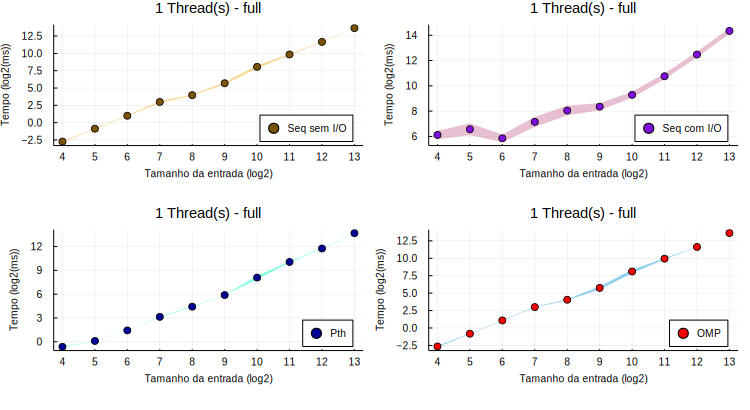

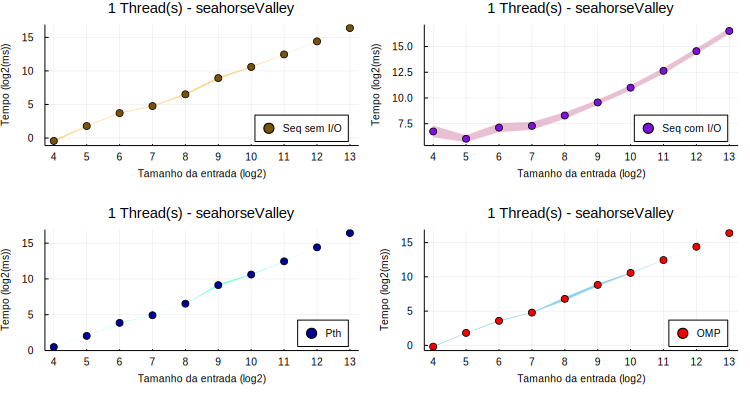

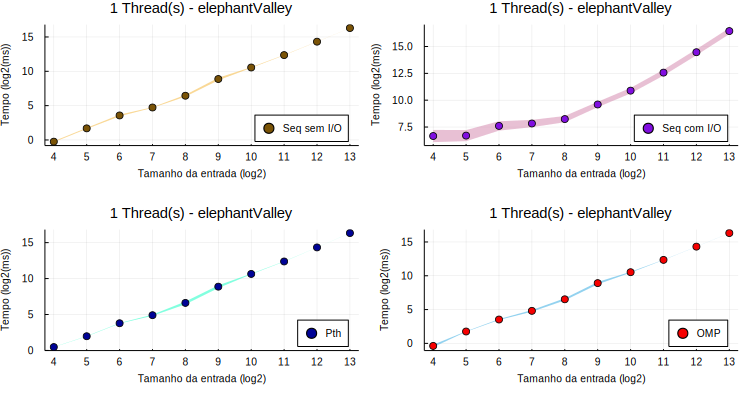

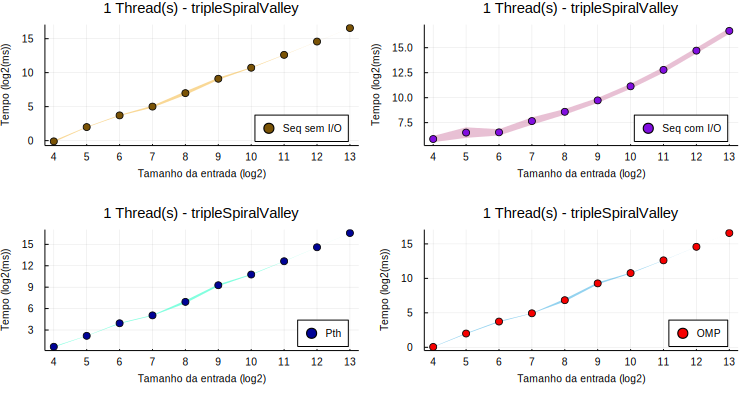

In [23]:
plot_by_number_of_threads(2^0)

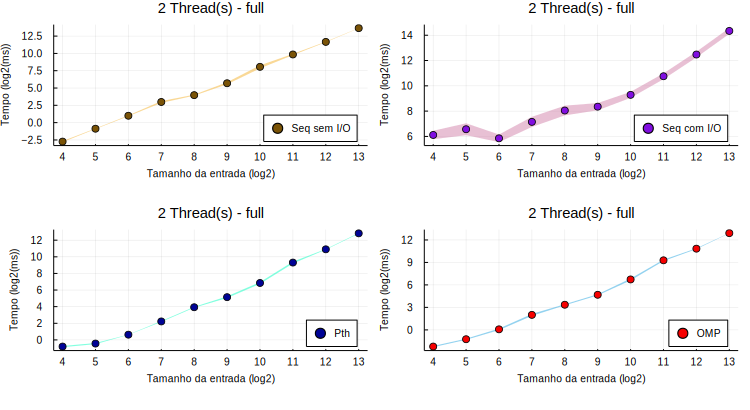

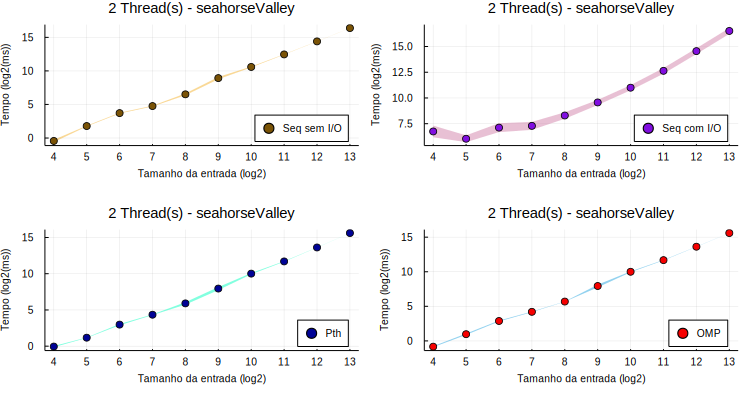

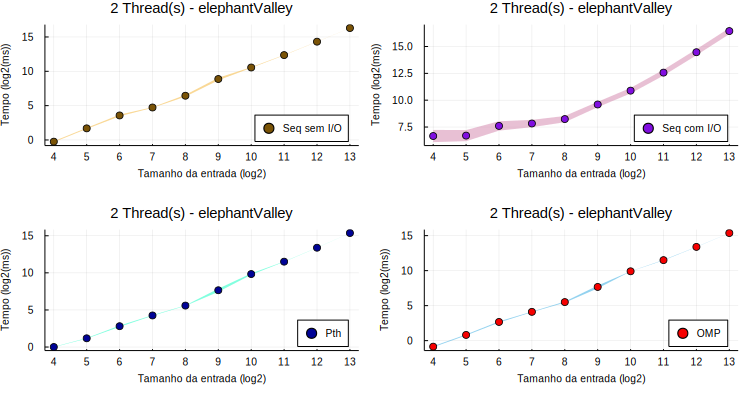

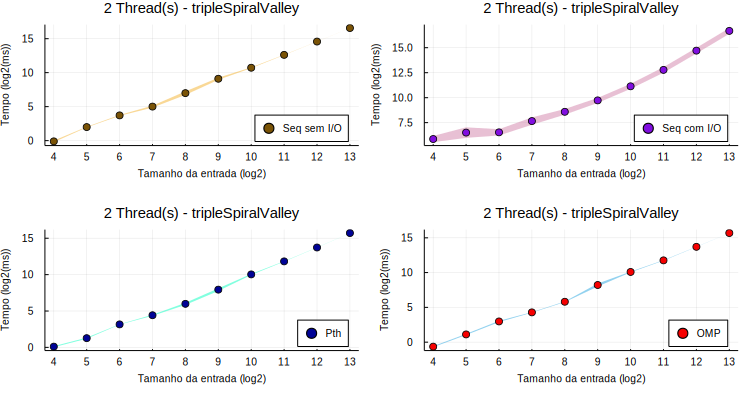

In [24]:
plot_by_number_of_threads(2^1)

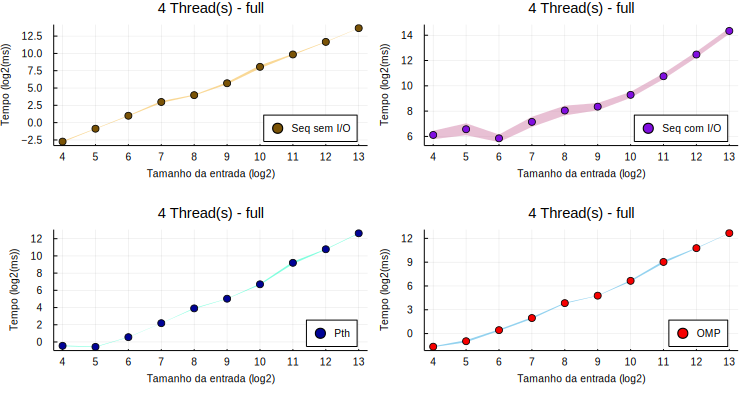

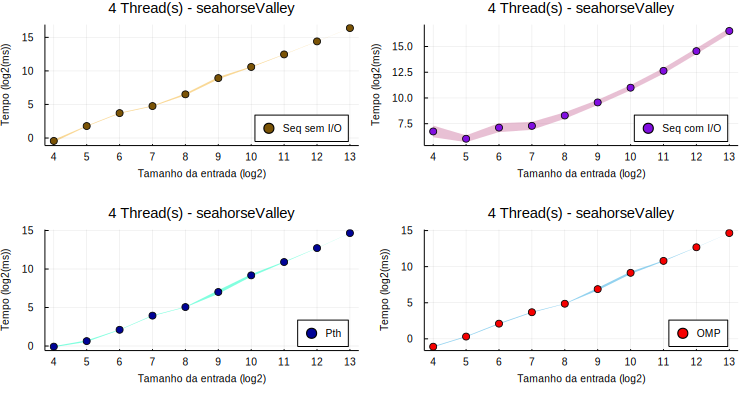

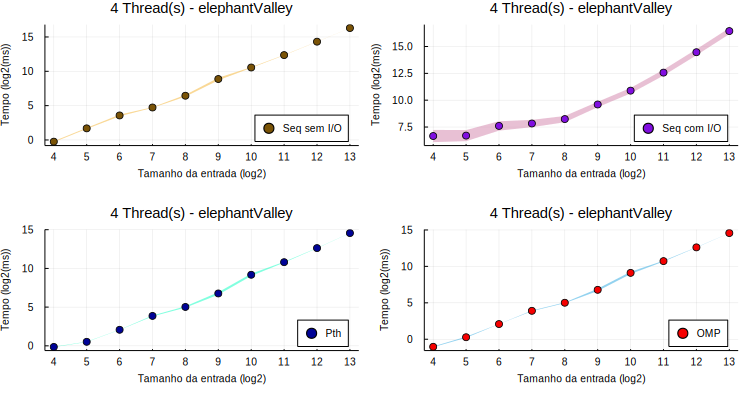

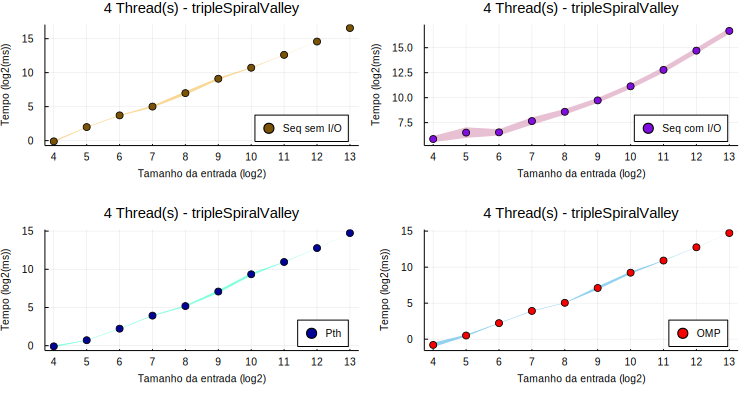

In [25]:
plot_by_number_of_threads(2^2)

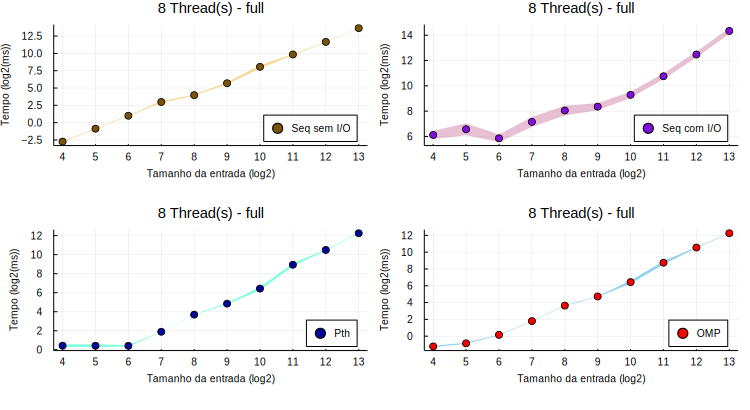

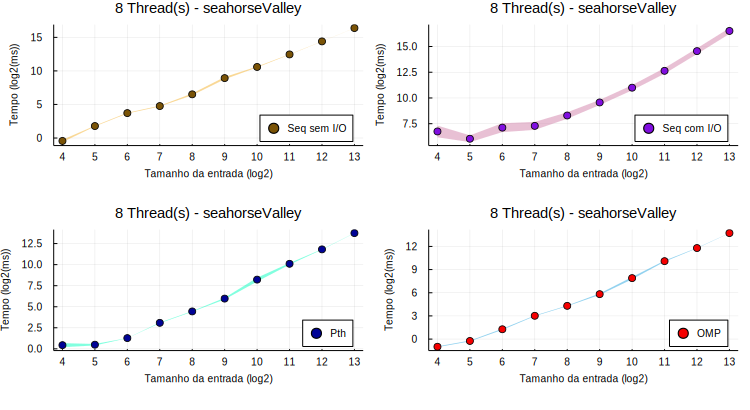

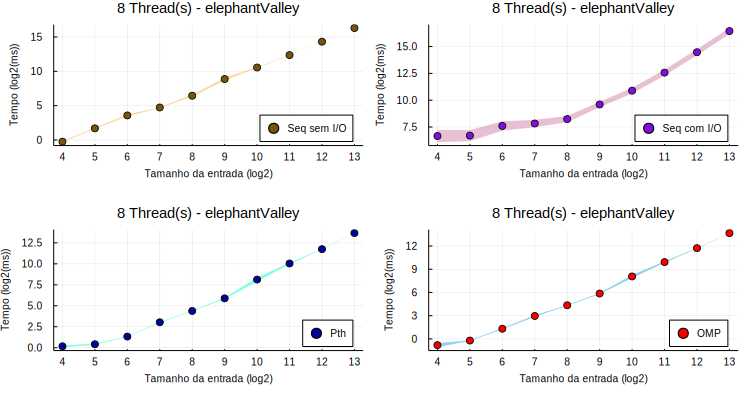

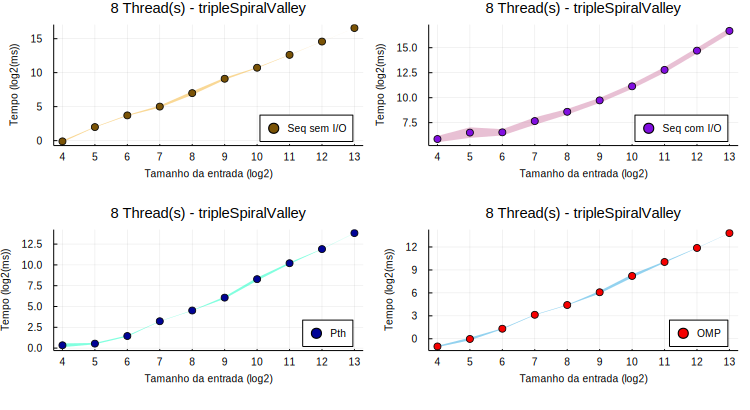

In [26]:
plot_by_number_of_threads(2^3)

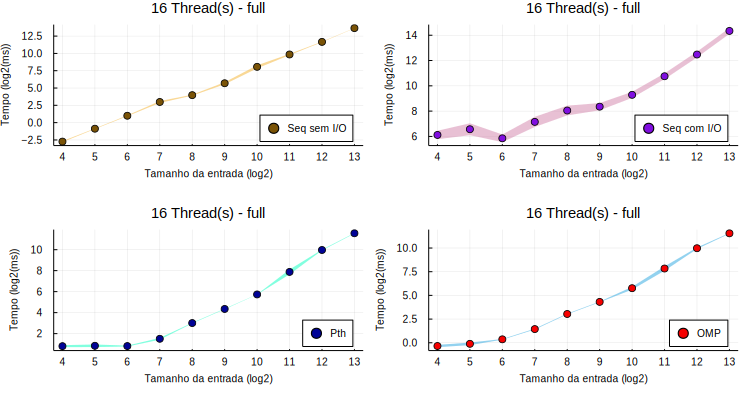

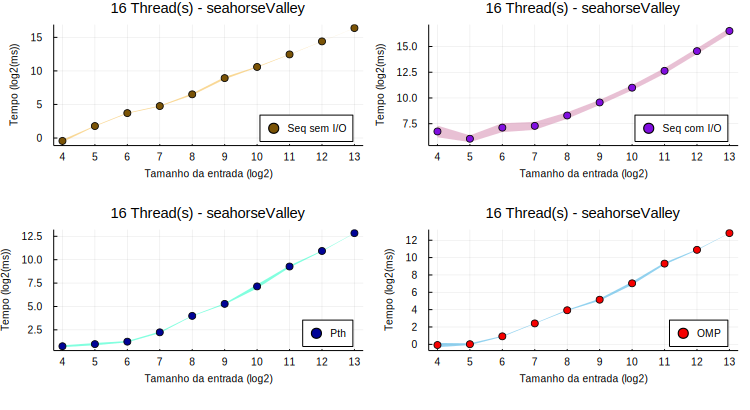

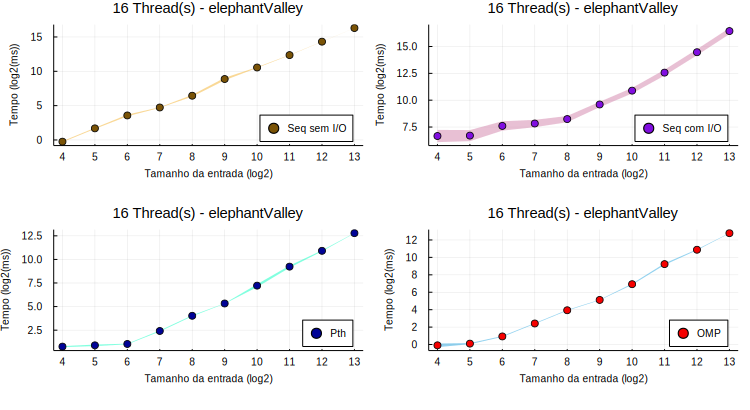

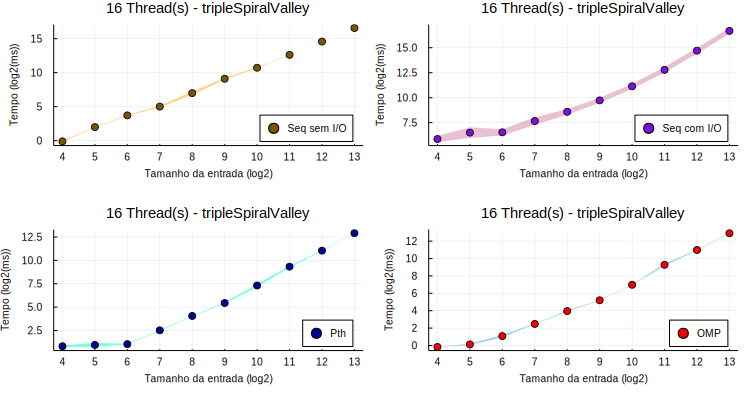

In [27]:
plot_by_number_of_threads(2^4)

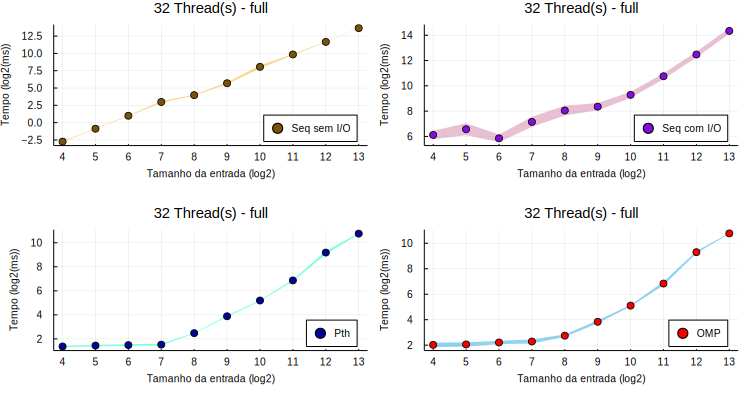

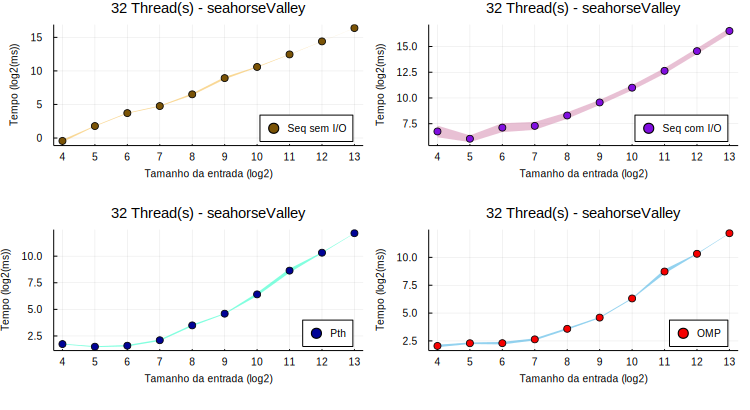

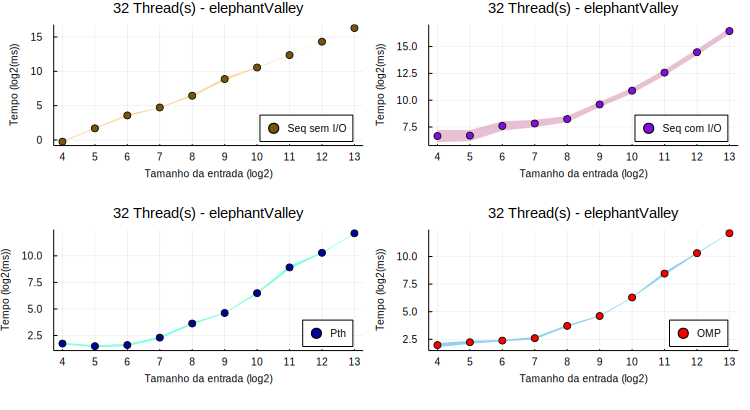

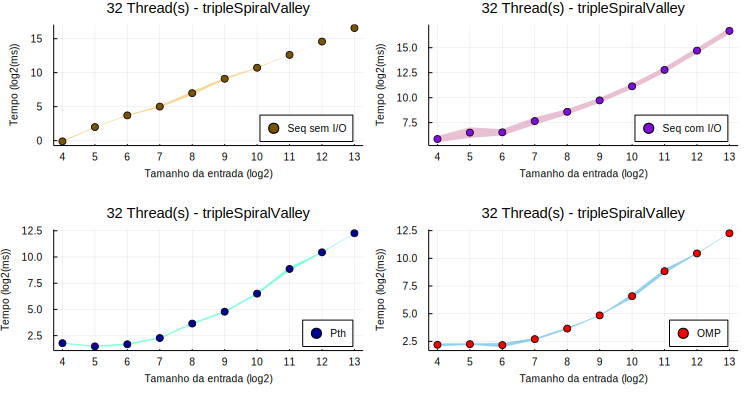

In [28]:
plot_by_number_of_threads(2^5)

## Resultados

### Como e por que as três versões do programa se comportam com a variação:


* **Do tamanho da entrada?**
    
    O tempo gasto é proporcional ao tamanho da entrada independentemente da versão. Além disto, podemos ver que todos os gráficos possuem o mesmo formato mas com valores diferentes. Isto ocorre pois, em qualquer método escolhido para fazer a computação, um aumento no tamanho da entrada implica em mais trabalho a ser realizado e todos os métodos reagem de forma similar à este aumento. 
        
        
* **Das regiões do Conjunto de Mandelbrot?**
    
     O tempo gasto na figura *full* é relativamente menor do que o tempo gasto nas outras figuras na versão sequencial. Isto ocorre pois, em relação ao limitante *escape_radius_squared* definido, os pixels da figura *full* divergem em menos iterações do que os pixels das outras figuras, fazendo com que o programa execute mais rapidamente. Nas versões paralelizadas, a diferença de tempo gasto entre as figuras é relativa à quantidade de threads.
        
        
* **Do número de threads?**
    
    Conforme o número de threads aumenta, conseguimos observar, para tamanhos cada vez maiores de entrada, uma redução do tempo cada vez mais proporcional ao número de threads. Isto ocorre pois, quando começamos a ter tamanhos de entrada cada vez maiores, o benefício do uso das threads e da divisão do trabalho acabam superando o seu custo de criação.
    
    Além disso, observamos que, nas versões paralelizadas, quanto maior o número de threads, menor é a diferença de tempo gasto entre as imagens. Isto ocorre pois quanto mais dividimos a imagem em diferentes seções, mais homogênea fica a distribuição dos pixels que demoram muitas iterações para divergir e, portanto, as seções demoram relativamente o mesmo tempo. Assim o programa executa em menos tempo, pois mais threads executarão e terminarão juntas.
 
### Qual o impacto das operações de I/O e alocação de memória no tempo de execução?

Analisando o código, podemos perceber que as operações de I/O e alocação de memória gastam tempo proporcional a t^2 (O(t^2)), onde t é o tamanho da entrada. Podemos notar, então, que a influência dessas operações no tempo é relativa entre os pontos e, para valores de entrada pequenos, o tempo de processamento é ínfimo enquanto a maior parte do tempo gasto pela execução do programa é realizando essas operações.